# <span style="color:darkgreen;">Análise de Preços de Combustíveis por Região no Brasil</span>

**Objetivo:** Analisar a evolução do preço médio de venda da Gasolina Comum e do Etanol Hidratado por região do Brasil (Norte, Nordeste, Centro-Oeste, Sudeste, Sul) entre o primeiro semestre de 2022 e o primeiro semestre de 2025.

In [56]:
# Célula 1: Importação de Bibliotecas

print("Importando bibliotecas de análise e forecasting...")

# --- Bibliotecas Padrão de Análise de Dados ---
import pandas as pd
import os
import glob

# --- Bibliotecas de Visualização ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Biblioteca de Forecasting (Séries Temporais) ---
from prophet import Prophet

# --- Configuração global do tema Seaborn ---
# Define o estilo padrão para todos os gráficos do notebook como "whitegrid"
# Isso adiciona automaticamente as linhas de grade horizontais e verticais.
sns.set_theme(style="whitegrid")

print("Bibliotecas carregadas e tema visual definido com sucesso.")

Importando bibliotecas de análise e forecasting...
Bibliotecas carregadas e tema visual definido com sucesso.


In [57]:
# Célula 2: Carga e Unificação dos Dados (Versão Otimizada)

print("Iniciando carga de dados...")

# Define o caminho para a pasta de dados
# Usamos '../dados' assumindo que o notebook está em uma subpasta (ex: 'notebooks/')
caminho_dados = '../dados'

# Usando glob para encontrar todos os arquivos .csv no diretório de dados
# O os.path.join garante que o caminho seja montado corretamente em qualquer sistema operacional.
arquivos_csv = glob.glob(os.path.join(caminho_dados, "*.csv"))

# Otimização: Carregar e concatenar os arquivos usando uma expressão geradora.
# É mais eficiente em termos de memória do que criar uma lista de dataframes primeiro.
df_completo = pd.concat(
    (pd.read_csv(arquivo, sep=';', decimal=',') for arquivo in arquivos_csv),
    ignore_index=True
)

print(f"Dados carregados e unificados com sucesso.")
print(f"Total de registros carregados: {len(df_completo)}")

# Exibe as primeiras linhas e informações gerais para verificação inicial
df_completo.head()

Iniciando carga de dados...


C:\Users\jfmat\AppData\Local\Temp\ipykernel_14960\3954815401.py:16: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(arquivo, sep=';', decimal=',') for arquivo in arquivos_csv),


Dados carregados e unificados com sucesso.
Total de registros carregados: 3139561


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GASOLINA,03/01/2022,6.99,NaN,R$ / litro,VIBRA ENERGIA
1,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,ETANOL,03/01/2022,5.99,NaN,R$ / litro,VIBRA ENERGIA
2,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,DIESEL,03/01/2022,6.09,NaN,R$ / litro,VIBRA ENERGIA
3,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GASOLINA ADITIVADA,03/01/2022,7.05,NaN,R$ / litro,VIBRA ENERGIA
4,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,DIESEL S10,03/01/2022,6.12,NaN,R$ / litro,VIBRA ENERGIA


In [58]:
# Célula 3: Limpeza, Transformação e Enriquecimento de Dados

print("Iniciando processamento e enriquecimento dos dados...")

# --- Definição dos Parâmetros da Análise ---

# 1. Lista de produtos que queremos analisar
produtos_desejados = ['GASOLINA', 'ETANOL', 'DIESEL S10', 'GNV']

# 2. Mapa de Regiões do Brasil
# Primeiro, definimos as listas lógicas de estados por região:
regioes_estados = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Agora, usamos Dict Comprehension aninhada para "inverter" o dicionário
# Criando o mapa (Estado -> Região) necessário para a função .map()
mapa_regioes = {estado: regiao for regiao, estados in regioes_estados.items() for estado in estados}

# --- Otimização com Method Chaining (Pipeline principal) ---
df_filtrado = (
    df_completo
    # Etapa 1: Filtrar produtos desejados
    .query("Produto in @produtos_desejados")

    # Etapa 2: Remover valores nulos na coluna principal da análise
    .dropna(subset=['Valor de Venda'])

    # Etapa 3: Aplicar transformações e criar novas colunas
    .assign(
        Data_Coleta = lambda df: pd.to_datetime(df['Data da Coleta'], format='%d/%m/%Y'),
        # Etapa 3b: Cria a coluna 'Regiao' usando o mapa gerado automaticamente
        Regiao = lambda df: df['Estado - Sigla'].map(mapa_regioes)
    )
)

print("Processamento concluído.")
print(f"Registros restantes após filtragem e processamento: {len(df_filtrado)}")
print("\nVerificação das colunas criadas:")
df_filtrado[['Data_Coleta', 'Regiao', 'Estado - Sigla']].head()

Iniciando processamento e enriquecimento dos dados...
Processamento concluído.
Registros restantes após filtragem e processamento: 2153651

Verificação das colunas criadas:


,Data_Coleta,Regiao,Estado - Sigla
0,2022-01-03,Norte,AC
1,2022-01-03,Norte,AC
4,2022-01-03,Norte,AC
5,2022-01-03,Norte,AC
6,2022-01-03,Norte,AC


Iniciando agregação final dos dados...
Agregação concluída. Gerando visualização final...
Gráfico final gerado e salvo com sucesso em: ../imagens/evolucao_precos_por_regiao.png


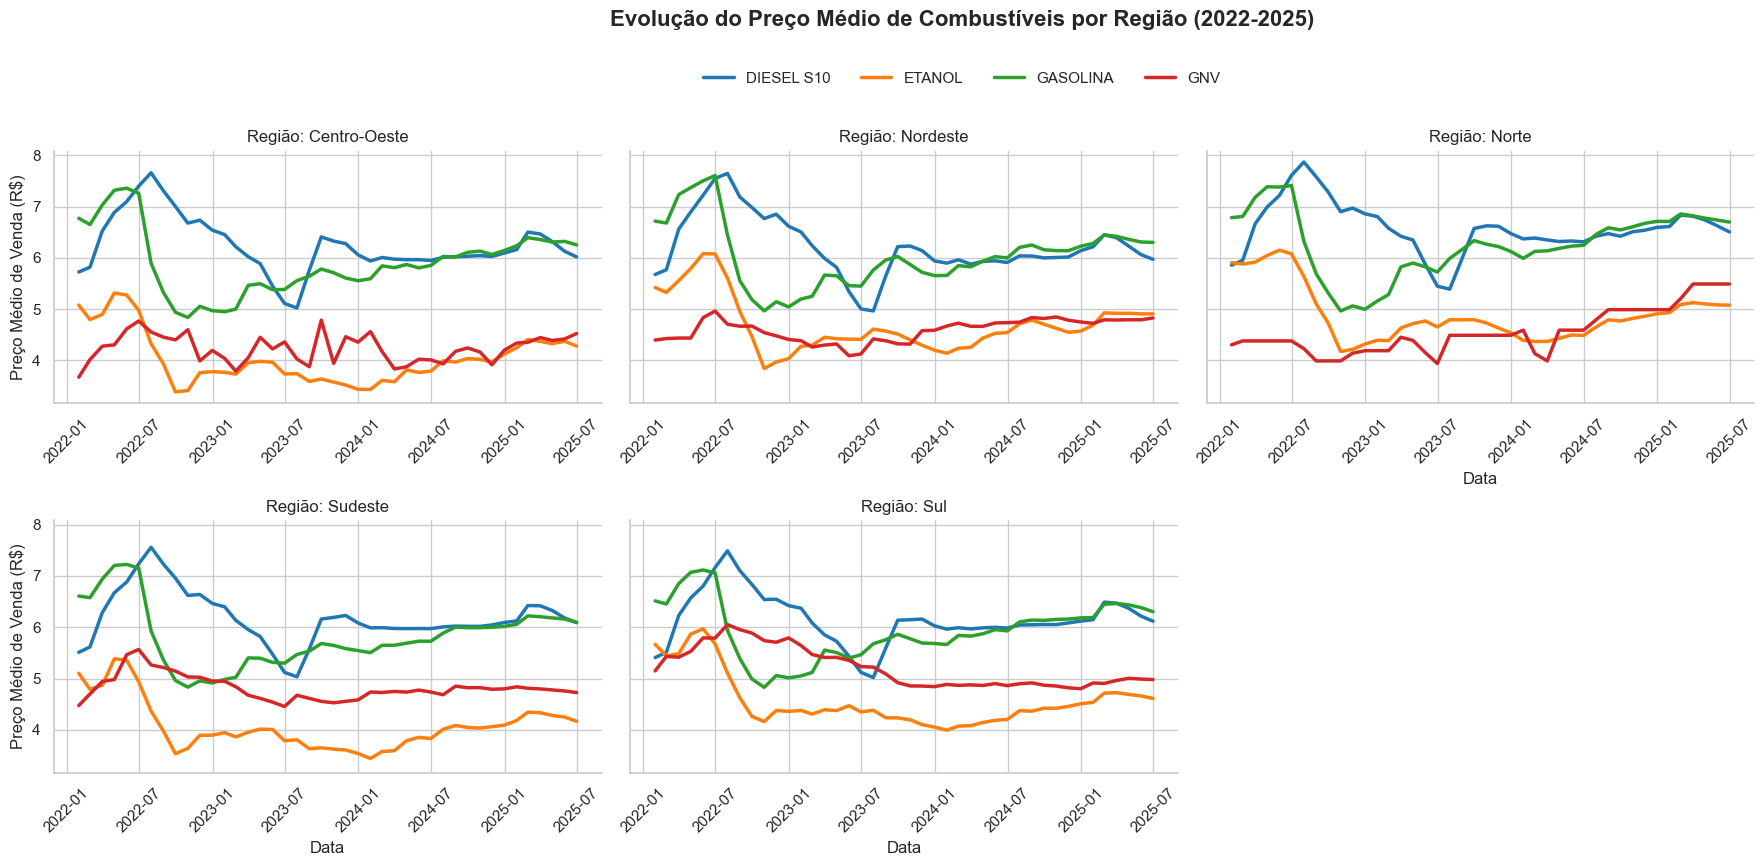

In [59]:
# Célula 4: Agregação e Visualização

print("Iniciando agregação final dos dados...")

# --- Etapa 1: Agregação ---
# Calculamos a média do 'Valor de Venda' agrupando por mês (usando pd.Grouper)
# e pelas categorias 'Regiao' e 'Produto' para preparar os dados para o gráfico.
df_analise = df_filtrado.groupby(
    ['Regiao', pd.Grouper(key='Data_Coleta', freq='ME'), 'Produto']
)['Valor de Venda'].mean().reset_index()

print("Agregação concluída. Gerando visualização final...")

# --- Etapa 2: Visualização ---
# O tema 'whitegrid' definido globalmente na Célula 1 já aplicará o estilo de grade.
g = sns.relplot(
    data=df_analise,
    x='Data_Coleta',
    y='Valor de Venda',
    hue='Produto',
    col='Regiao',
    kind='line',
    col_wrap=3,        # Máximo de 3 colunas de gráficos por linha
    height=4,          # Altura de cada gráfico
    aspect=1.5,        # Proporção largura/altura
    linewidth=2.5,     # Espessura das linhas
    palette='tab10',
    facet_kws={'sharex': False, 'sharey': True} # Garante eixos X independentes
)

# Ajustes de Títulos e Rótulos Gerais
g.fig.suptitle('Evolução do Preço Médio de Combustíveis por Região (2022-2025)', y=1.08, fontsize=16, weight='bold')
g.set_axis_labels("Data", "Preço Médio de Venda (R$)")
g.set_titles("Região: {col_name}")

# --- Ajustes Individuais (Loop pelos eixos) ---
for ax in g.axes.flat:
    # Ajusta a rotação dos rótulos do eixo X para melhor legibilidade
    ax.tick_params(axis='x', rotation=45)
    # OBS: A linha manual 'ax.grid()' foi removida daqui, pois o tema global já trata disso.

# --- Ajuste da Posição da Legenda ---
sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(.5, 1.02),
    ncol=4,
    title=None, frameon=False,
)

g.tight_layout(w_pad=1, h_pad=2)

# --- Salvamento do Gráfico ---
caminho_salvar_imagem = '../imagens/evolucao_precos_por_regiao.png'
plt.savefig(caminho_salvar_imagem, dpi=300, bbox_inches='tight')

print(f"Gráfico final gerado e salvo com sucesso em: {caminho_salvar_imagem}")
plt.show()

Iniciando processo de forecasting...
Preparando previsão para: GASOLINA na região Sudeste
Total de pontos de dados diários para o modelo: 905


11:46:11 - cmdstanpy - INFO - Chain [1] start processing
11:46:12 - cmdstanpy - INFO - Chain [1] done processing


Previsão gerada. Plotando resultados...
Gráficos de previsão salvos em: ../imagens/forecast_gasolina_sudeste.png e ../imagens/forecast_components_gasolina_sudeste.png


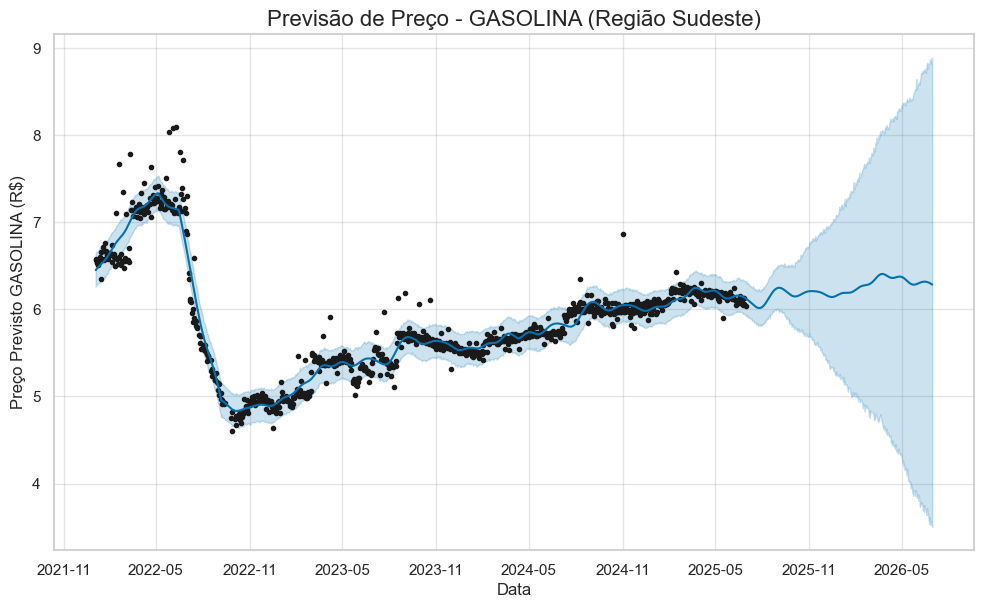

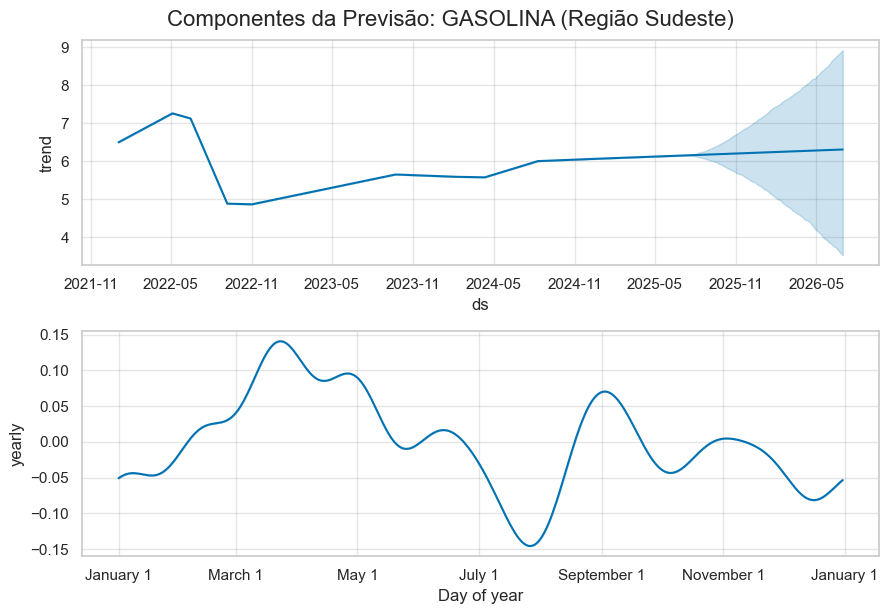

In [60]:
# Célula 5: Previsão de Série Temporal com Prophet (Região Sudeste)

print("Iniciando processo de forecasting...")

# --- 1. Preparação dos Dados para o Prophet ---

# Escolha do combustível e região para focar a previsão
produto_foco = 'GASOLINA'
regiao_foco = 'Sudeste'

# Filtra o dataframe principal para a série temporal específica
# Usamos .query() para manter a consistência com a otimização da Célula 3
df_serie_temporal_foco = df_filtrado.query("Regiao == @regiao_foco and Produto == @produto_foco")

# Prophet funciona melhor com dados agregados por período (dia, neste caso).
# Calculamos a média diária para a série escolhida.
df_agregado_dia = df_serie_temporal_foco.groupby('Data_Coleta')['Valor de Venda'].mean().reset_index()

# Renomear colunas para o formato exigido pelo Prophet: 'ds' (data) e 'y' (valor)
df_prophet = df_agregado_dia[['Data_Coleta', 'Valor de Venda']].rename(columns={
    'Data_Coleta': 'ds',
    'Valor de Venda': 'y'
})

print(f"Preparando previsão para: {produto_foco} na região {regiao_foco}")
print(f"Total de pontos de dados diários para o modelo: {len(df_prophet)}")

# --- 2. Treinamento do Modelo ---

# Inicializa o modelo Prophet.
# yearly_seasonality=True é importante para capturar padrões anuais.
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Treina o modelo com os dados formatados
model.fit(df_prophet)

# --- 3. Criação do DataFrame Futuro ---

# Define o horizonte de previsão: 2 semestres = 365 dias
horizonte_dias = 365
future = model.make_future_dataframe(periods=horizonte_dias)

# --- 4. Geração da Previsão ---
forecast = model.predict(future)

# --- 5. Visualização dos Resultados ---

print("Previsão gerada. Plotando resultados...")

# Plotagem principal da previsão
# O estilo de grade será aplicado automaticamente pelo tema definido na Célula 1.
fig1 = model.plot(forecast, xlabel='Data', ylabel=f'Preço Previsto {produto_foco} (R$)')
ax = fig1.gca()
ax.set_title(f'Previsão de Preço - {produto_foco} (Região {regiao_foco})', size=16)

# Salvar o gráfico da previsão
caminho_salvar_previsao = f'../imagens/forecast_{produto_foco.lower()}_{regiao_foco.lower()}.png'
fig1.savefig(caminho_salvar_previsao, dpi=300, bbox_inches='tight')

# Plotagem dos componentes da série temporal (Tendência e Sazonalidade Anual)
fig2 = model.plot_components(forecast)
fig2.suptitle(f'Componentes da Previsão: {produto_foco} (Região {regiao_foco})', y=1.02, size=16)
caminho_salvar_componentes = f'../imagens/forecast_components_{produto_foco.lower()}_{regiao_foco.lower()}.png'
fig2.savefig(caminho_salvar_componentes, dpi=300, bbox_inches='tight')

print(f"Gráficos de previsão salvos em: {caminho_salvar_previsao} e {caminho_salvar_componentes}")

---

## <span style="color:darkgreen;">Conclusão Técnica dos Resultados do Notebook</span>

A execução deste notebook atingiu com sucesso os objetivos de análise descritiva e preditiva propostos.

**1. Análise Histórica (Ref. Célula 4):**
A visualização facetada (gráfico `evolucao_precos_por_regiao.png`) validou a metodologia de ETL e permitiu confirmar visualmente as seguintes hipóteses:

* **Análise por Produto:** A Gasolina e o Diesel S10 competem consistentemente pelos postos de combustíveis mais caros, enquanto o Etanol e o GNV (onde disponível) se consolidam como as alternativas econômicas.
* **Análise Regional (Preços Altos):** As regiões **Norte** e **Nordeste** apresentam custos estruturalmente mais elevados para combustíveis fósseis (Gasolina/Diesel), refletindo desafios logísticos de distribuição.
* **Análise Regional (Preços Baixos):** As regiões **Sudeste** e **Centro-Oeste** demonstram ser as mais competitivas do país, apresentando os preços médios mais baixos, especialmente para o Etanol, devido à proximidade dos polos produtores.
* **Análise de Eventos:** A mudança na legislação do ICMS em meados de 2022 foi confirmada como o ponto de inflexão mais significativo da série, causando uma queda estrutural (não sazonal) abrupta em todos os produtos, em todas as regiões.

**2. Análise Preditiva (Ref. Célula 5):**
O modelo Prophet foi treinado com sucesso para a série temporal da Gasolina na Região Sudeste.

* **Previsão (yhat):** O modelo prevê uma leve tendência de alta contínua para os próximos 12 meses, extrapolando a recuperação gradual observada desde o final de 2022.
* **Incerteza (yhat_upper / yhat_lower):** O principal insight do modelo é o alargamento drástico do intervalo de confiança de 80%. Isso demonstra matematicamente que, devido à alta instabilidade histórica (choques políticos e fiscais) e à dependência de fatores externos, previsões de longo prazo para este mercado possuem **elevada incerteza estatística**.
* **Componentes:** A decomposição do modelo isolou com sucesso a Tendência (identificando o "changepoint" de 2022) e uma clara Sazonalidade Anual (picos no 1º semestre e vales no 2º semestre).

Os artefatos visuais gerados na pasta `imagens/` e as conclusões técnicas acima servem como base direta para o desenvolvimento textual do relatório acadêmico principal.